# Atoti Value-at-Risk benchmark

This notebook is a benchmark template used to expose Atoti performances over ClickHouse by reproducing a benchmark detailed in a [blog post by Altinity on calculating Value-at-Risk (VaR)](https://altinity.com/blog/clickhouse-vs-redshift-performance-for-fintech-risk-management). Check out the [full article](https://www.activeviam.com/blog/atoti-for-risk-management-aggregation-comparison-with-the-clickhouse-benchmark/)

  
<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=var-benchmark" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover+Atoti+now.jpg" alt="Atoti" /></a></div>

In [1]:
import time

import atoti

In [2]:
session = atoti.Session(
    name="RiskBenchmark", java_options=["-XX:MaxDirectMemorySize=12G"]
)

In [3]:
# Load risk dataset
dataset = session.read_parquet(
    "dataset.parquet",
    partitioning="hash32(str0)",
    default_values={"int10": 0, "int11": 0, "int12": 0, "int13": 0},
)

In [4]:
cube = session.create_cube(dataset)

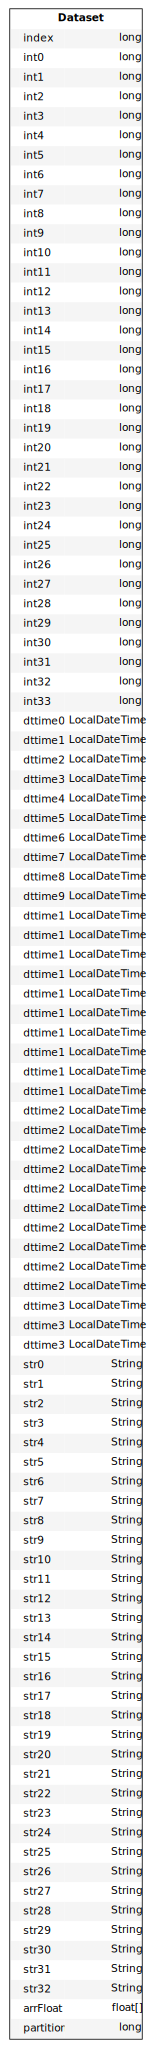

In [5]:
cube.schema

In [6]:
# Disable the aggregate cache
cube.aggregates_cache.capacity = -1

In [7]:
# Define vector aggregation and value at risk
h, m, l = cube.hierarchies, cube.measures, cube.levels

m["PnlVector"] = atoti.agg.sum(dataset["arrFloat"])
m["ValueAtRisk"] = atoti.array.quantile(m["PnlVector"], q=0.95)

In [8]:
# Create a hierarchy to access vector elements
cube.create_parameter_hierarchy_from_members("Scenarios", list(range(0, 1000)))
m["PnL at index"] = m["PnlVector"][l["Scenarios"]]

Creating hierarchies for numerical columns required for querying.

In [9]:
h["int10"] = [dataset["int10"]]
h["int11"] = [dataset["int11"]]
h["int12"] = [dataset["int12"]]
h["int13"] = [dataset["int13"]]

In [10]:
session.link()

Open the notebook in JupyterLab with the Atoti extension enabled to see this link.

In [11]:
# Number of facts in the cube
cube.query(m["contributors.COUNT"])

,contributors.COUNT
0,"1,720,000"


### Query Benchmark

In [12]:
def Q1():
    return cube.query(m["ValueAtRisk"], levels=[l["str0"]], mode="raw")


def Q2():
    return cube.query(
        m["ValueAtRisk"],
        levels=[
            l["str0"],
            l["str1"],
            l["int10"],
            l["int11"],
            l["dttime10"],
            l["dttime11"],
        ],
        mode="raw",
    )


def Q3():
    return cube.query(
        m["ValueAtRisk"],
        levels=[
            l["str0"],
            l["str1"],
            l["str2"],
            l["str3"],
            l["int10"],
            l["int11"],
            l["int12"],
            l["int13"],
            l["dttime10"],
            l["dttime11"],
            l["dttime12"],
            l["dttime13"],
        ],
        mode="raw",
    )


def Q4():
    return cube.query(
        m["PnL at index"],
        levels=[l["str0"], l["Scenarios"]],
        filter=(l["str1"] == "KzORBHFRuFFOQm"),
        mode="raw",
    )


# Iterations
iterations = 10


def benchmark(name, task):
    # Warmup
    for w in range(10):
        task()

    start = time.time()
    for i in range(iterations):
        task()
    elapsed = time.time() - start

    print(f"{name} average query time {round(1000*elapsed/iterations)} ms")

In [13]:
benchmark("Q1", Q1)

Q1 average query time 185 ms


In [14]:
benchmark("Q2", Q2)

Q2 average query time 284 ms


In [15]:
benchmark("Q3", Q3)

Q3 average query time 313 ms


In [16]:
benchmark("Q4", Q4)

Q4 average query time 86 ms


### Launch queries manually

In [17]:
%%time
Q1()

CPU times: total: 0 ns
Wall time: 144 ms


,str0,ValueAtRisk
0,YOeccFqbHQKKn,10606052352.0
1,YQOaNFvp,9661348864.0
2,zqnPcZ,9242836992.0
3,UpdtlH,8829149184.0
4,MLoZbQaVltGKqveF,9686873088.0
...,...,...
95,NiOug,9406148608.0
96,KzORBHFRuFFOQm,10108854272.0
97,SJPwm,8503491584.0
98,feZfmVod,8236514304.0


In [18]:
%%time
Q2()

CPU times: total: 15.6 ms
Wall time: 282 ms


,str0,str1,int10,int11,dttime10,dttime11,ValueAtRisk
0,YOeccFqbHQKKn,NOnJECHqdZJafUzT,292574,-593941,2025-01-07 19:09:09,2030-07-12 10:17:44,164233456.0
1,YQOaNFvp,sWRmMfceYqtIvhHpWke,-497521,-467426,2032-01-01 08:46:07,2026-09-07 09:45:49,164582592.0
2,YOeccFqbHQKKn,MLoZbQaVltGKqveF,-625869,-975223,2023-06-16 06:27:04,2023-06-16 06:27:04,162385360.0
3,YQOaNFvp,yYXXFhdNS,531028,132931,2028-02-12 17:29:03,2024-06-16 02:29:16,163682128.0
4,YOeccFqbHQKKn,ehwSbwwlaoxeMjn,-658155,234801,2042-05-01 15:21:54,2031-05-05 00:22:11,162755136.0
...,...,...,...,...,...,...,...
9995,SJPwm,ssJOul,-625686,872245,2022-07-30 12:17:58,2033-10-25 10:16:43,162557312.0
9996,feZfmVod,DVfvVcIripWEw,62216,-616430,2035-06-26 09:26:00,2037-04-07 17:00:51,163910080.0
9997,feZfmVod,LrCFQPSYwfu,292574,-891517,2047-02-27 23:49:30,2025-01-07 19:09:09,163082016.0
9998,SJPwm,ABlpDvHjwDOOfEWn,-898739,-227342,2023-03-04 13:01:59,2047-04-27 09:33:34,163419088.0


In [19]:
%%time
Q3()

CPU times: total: 0 ns
Wall time: 294 ms


,str0,str1,str2,str3,int10,int11,int12,int13,dttime10,dttime11,dttime12,dttime13,ValueAtRisk
0,YOeccFqbHQKKn,NOnJECHqdZJafUzT,YmcYzCxWmDw,YiyZsVRZhH,292574,-593941,475712,796107,2025-01-07 19:09:09,2030-07-12 10:17:44,2029-01-23 02:19:04,2037-11-19 14:02:07,164233456.0
1,YQOaNFvp,sWRmMfceYqtIvhHpWke,feZfmVod,HeRfRVQza,-497521,-467426,-891899,-583478,2032-01-01 08:46:07,2026-09-07 09:45:49,2034-03-04 00:08:04,2019-05-30 01:12:30,164582592.0
2,YOeccFqbHQKKn,MLoZbQaVltGKqveF,tJAVjLBtOwfpCO,rsCxKOikhShyzLDiJ,-625869,-975223,234801,609814,2023-06-16 06:27:04,2023-06-16 06:27:04,2022-07-30 12:17:58,2037-03-24 06:24:03,162385360.0
3,YQOaNFvp,yYXXFhdNS,YiyZsVRZhH,jtgUe,531028,132931,-604366,-518622,2028-02-12 17:29:03,2024-06-16 02:29:16,2048-08-28 10:49:32,2037-03-24 06:24:03,163682128.0
4,YOeccFqbHQKKn,ehwSbwwlaoxeMjn,LrCFQPSYwfu,UuCnxsEflYg,-658155,234801,666654,-549890,2042-05-01 15:21:54,2031-05-05 00:22:11,2032-06-24 20:03:07,2047-04-27 09:33:34,162755136.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,SJPwm,ssJOul,fMZyuKpslm,anQRUhVasxSbMoj,-625686,872245,810688,810688,2022-07-30 12:17:58,2033-10-25 10:16:43,2047-04-27 09:33:34,2019-05-30 01:12:30,162557312.0
9996,feZfmVod,DVfvVcIripWEw,lcNQqEe,NhFLOvmpbUrhT,62216,-616430,872245,85649,2035-06-26 09:26:00,2037-04-07 17:00:51,2024-06-16 02:29:16,2020-04-26 06:04:06,163910080.0
9997,feZfmVod,LrCFQPSYwfu,RzTHrHZpnRLA,rsCxKOikhShyzLDiJ,292574,-891517,793119,-181783,2047-02-27 23:49:30,2025-01-07 19:09:09,2027-08-31 07:00:40,2037-12-09 20:09:17,163082016.0
9998,SJPwm,ABlpDvHjwDOOfEWn,anQRUhVasxSbMoj,tJAVjLBtOwfpCO,-898739,-227342,-550428,-134640,2023-03-04 13:01:59,2047-04-27 09:33:34,2038-05-05 02:46:21,2037-04-07 17:00:51,163419088.0


In [20]:
%%time
Q4()

CPU times: total: 0 ns
Wall time: 66.4 ms


,str0,Scenarios,PnL at index
0,BNgqeo,0,171094576.0
1,BNgqeo,1,124104936.0
2,BNgqeo,2,274138112.0
3,BNgqeo,3,99970464.0
4,BNgqeo,4,276821120.0
...,...,...,...
60995,QtwOEVAnEFSGuF,995,101288288.0
60996,QtwOEVAnEFSGuF,996,144882832.0
60997,QtwOEVAnEFSGuF,997,144231344.0
60998,QtwOEVAnEFSGuF,998,164819968.0


  
<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=var-benchmark" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="Atoti" /></a></div>